In [9]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import json
from pathlib import Path
from typing import List, Tuple, Dict, Any, Mapping
from copy import deepcopy
from catalyst.dl import Experiment
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import catalyst.dl as dl
from collections import OrderedDict
from catalyst.contrib.nn import FocalLossBinary
from catalyst.dl import utils
from catalyst.data import BalanceClassSampler
from datasets import AdultDataSet, DatasetImbalanced
from models.transforms import ScalerTransform, ToTensor, Compose
from models.net import  TabularGAN
from runners import GANRunner

In [4]:
SEED = 42
utils.set_global_seed(SEED)
utils.prepare_cudnn(deterministic=True)

root = Path.cwd()
adult_train = AdultDataSet(root, train=True,
                           target_transform=ToTensor())

scaler_transform = ScalerTransform(adult_train.data, features=adult_train.continuous_cols)
# onehot_transform = OneHotTransform(adult_train.categorical_cols, adult_train.categories_sizes)
to_tensor = ToTensor()
# feat_transform = Compose([scaler_transform, onehot_transform, to_tensor])
feat_transform = Compose([scaler_transform, to_tensor])
adult_train.transform = feat_transform
adult_test = AdultDataSet(root, train=False,
                          transform=feat_transform,
                          target_transform=ToTensor())

# Creating imbalanced adult dataset
adult_train = DatasetImbalanced(imbalance_ratio=1)(adult_train)
adult_train, discarded_train = DatasetImbalanced(imbalance_ratio=0.1)(adult_train, return_complement=True)
adult_test = DatasetImbalanced(imbalance_ratio=1)(adult_test)
adult_test, discarded_test = DatasetImbalanced(imbalance_ratio=0.1)(adult_test, return_complement=True)

classifier_checkpoint = utils.load_checkpoint("classifier_best.pth")

<AxesSubplot:xlabel='x', ylabel='y'>

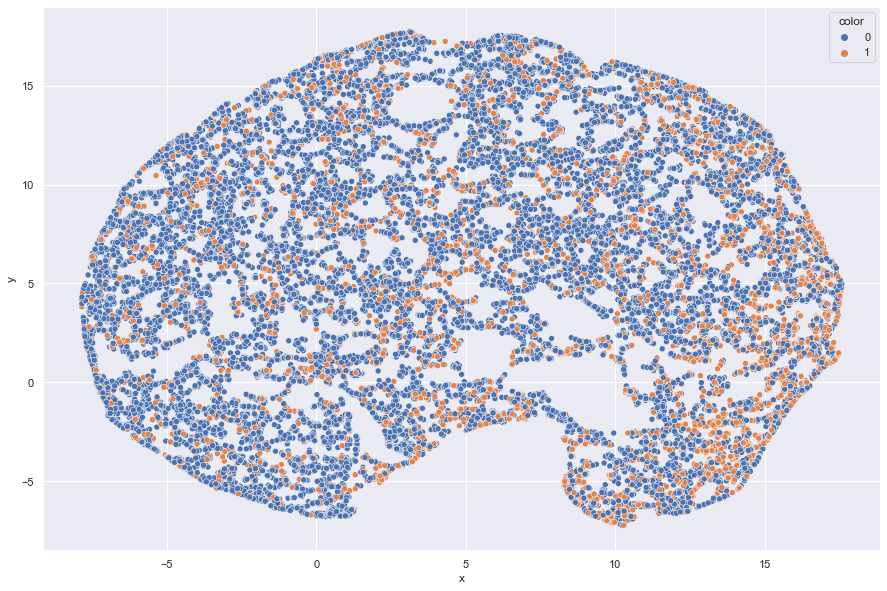

In [6]:
model = {"encoder": encoder,
         "classifier": classifier}
optimizer = torch.optim.Adam([{'params': classifier.parameters()},
                                {'params': encoder.parameters()}],
                                    lr=0.0003, betas=(0.5, 0.999))
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(adult_train.pos_weight))
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [10])
logdir = "dev_logs"
experiment_train = Experiment(model=model,
                        criterion=criterion,
                        optimizer=optimizer,
                        loaders=loaders,
                        logdir= logdir,
                        main_metric = "mAP",
                        minimize_metric=False,
                        scheduler=scheduler,
                        num_epochs=100,
                        callbacks = [
                                dl.CriterionCallback(),
                                dl.LoaderMetricCallback(input_key="targets",
                                   output_key="logits",
                                   prefix="mAP",
                                   metric_fn=average_precision_metric),
                                dl.LoaderMetricCallback(input_key="targets",
                                                    output_key="preds",
                                                    prefix="BalancedAccuracy",
                                                    metric_fn=balanced_accuracy_score),
                                dl.OptimizerCallback(),
                                dl.SchedulerCallback(),
                                dl.TensorboardLogger()
                        ])
experiment_inference = Experiment(model=model,
                       loaders={"infer": loaders["valid"]},
                       callbacks=OrderedDict([
                        ("load_checkpoint", dl.CheckpointCallback(resume=f"{logdir}/checkpoints/best.pth")),
                        ("precision_recall", LogPRCurve(log_dir=f"{logdir}/infer_log"))]),
                       stage="infer"
                       )
runner = ClassificationRunner()
runner.run_experiment(experiment_inference)


In [10]:
loaders = {
    "train": DataLoader(adult_train, batch_size=256, shuffle=True)
}

model = TabularGAN(adult_train.categorical_cols,
                   adult_train.continuous_cols,
                   adult_train.embeds)
utils.unpack_checkpoint(classifier_checkpoint,
                        model={"encoder": model.encoder})
optimizer = {
    "generator": torch.optim.Adam(model.generator.parameters(), lr=0.0003, betas=(0.5, 0.999)),
    "discriminator": torch.optim.Adam(model.discriminator.parameters(),
                                      lr=0.0003, betas=(0.5, 0.999)),
}

logdir = "gan_logs"
train = Experiment(model=model,
                        optimizer=optimizer,
                        loaders=loaders,
                        logdir=logdir,
                        main_metric="loss_generator",
                        minimize_metric=True,
                        num_epochs=100,
                        callbacks=[
                            dl.OptimizerCallback(optimizer_key="generator",
                                                 metric_key="loss_generator"),
                            dl.OptimizerCallback(optimizer_key="discriminator",
                                                 metric_key="loss_discriminator"),
                            dl.TensorboardLogger()
                        ])
runner = GANRunner()
runner.run_experiment(train)

In [2]:
import tensorflow as tf
import tensorboard as tb
from itertools import repeat, chain
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

checkpoint = utils.load_checkpoint(f"{logdir}/checkpoints/best.pth")
utils.unpack_checkpoint(checkpoint, model)

with torch.no_grad():
  SAMPLES, LATENT = 100, 10
  generator = model.generator.to('cpu')
  encoder = model.encoder.to('cpu')
  encoder.train(mode=False)
  majority_data = torch.cat([encoder(p["input"].unsqueeze(0)) for p in adult_train if p["label"]==0])
  minority_data = torch.cat([encoder(p["input"].unsqueeze(0)) for p in adult_train if p["label"]==1])
  samples_minority = torch.cat([torch.randn(SAMPLES, LATENT), torch.ones(SAMPLES,1)], dim=1)
  samples_majority = torch.cat([torch.randn(SAMPLES, LATENT), torch.zeros(SAMPLES,1)], dim=1)
  generated_samples_minority = generator(samples_minority)
  generated_samples_majority = generator(samples_majority)
mat = torch.cat([majority_data, minority_data,
                 generated_samples_minority, generated_samples_majority])
metadata = chain(repeat('0', majority_data.shape[0]),
                 repeat('1', minority_data.shape[0]),
                 repeat('gen_1', generated_samples_minority.shape[0]),
                 repeat('gen_0', generated_samples_majority.shape[0]))
writer = SummaryWriter(f"{logdir}/projection_log")
writer.add_embedding(mat, list(metadata), tag="encodings")



[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 22561 samples in 0.019s...
[t-SNE] Computed neighbors for 22561 samples in 2.094s...
[t-SNE] Computed conditional probabilities for sample 1000 / 22561
[t-SNE] Computed conditional probabilities for sample 2000 / 22561
[t-SNE] Computed conditional probabilities for sample 3000 / 22561
[t-SNE] Computed conditional probabilities for sample 4000 / 22561
[t-SNE] Computed conditional probabilities for sample 5000 / 22561
[t-SNE] Computed conditional probabilities for sample 6000 / 22561
[t-SNE] Computed conditional probabilities for sample 7000 / 22561
[t-SNE] Computed conditional probabilities for sample 8000 / 22561
[t-SNE] Computed conditional probabilities for sample 9000 / 22561
[t-SNE] Computed conditional probabilities for sample 10000 / 22561
[t-SNE] Computed conditional probabilities for sample 11000 / 22561
[t-SNE] Computed conditional probabilities for sample 12000 / 22561
[t-SNE] Computed conditional probabilities for sa